# Two dimensional problems using Scikit-fem

All connected domains in 1d are intervals. Already meshing is much more complicated in the 2d case as domains can have wildly different shapes. We are not going to discuss issues related to [mesh generation](https://en.wikipedia.org/wiki/Mesh_generation). Scikit-fem can generate some simple meshes. 

In [19]:
import numpy as np
from matplotlib import pyplot as plt
import skfem as fem
from skfem.models.poisson import laplace, unit_load

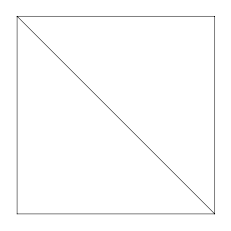

In [20]:
import skfem.visuals.matplotlib as fem_plt
mesh = fem.MeshTri()
fem_plt.draw(mesh);

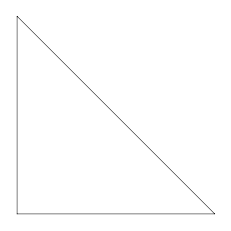

In [21]:
mesh = fem.MeshTri.init_refdom()
fem_plt.draw(mesh);

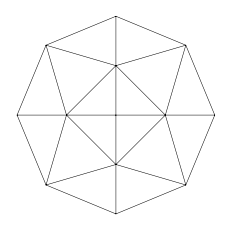

In [22]:
mesh = fem.MeshTri.init_circle(nrefs=1)
fem_plt.draw(mesh);

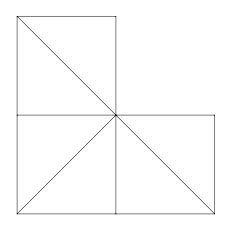

In [23]:
mesh = fem.MeshTri.init_lshaped()
fem_plt.draw(mesh);

These meshes can be transformed further, see for instance this [example](https://scikit-fem.readthedocs.io/en/latest/listofexamples.html#example-13-laplace-with-mixed-boundary-conditions). More complicated meshes can be created using [CAD](https://en.wikipedia.org/wiki/Computer-aided_design) software such as [FreeCAD](https://www.freecadweb.org/). Techniques based on signed distance functions can also be useful, see for example [this](https://github.com/fogleman/sdf) python package. [Here](https://scikit-fem.readthedocs.io/en/latest/listofexamples.html#example-21-structural-vibration) is an example on how to load a mesh with Scikit-fem. However, we are only going to use the four types of basic meshes plotted above. 

Mesh refinement works as in the 1d case.

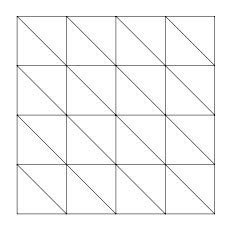

In [24]:
mesh = fem.MeshTri().refined(2)
fem_plt.draw(mesh);

Let's solve Poisson's problem in the unit square $(0,1)^2$ with unit load.

In [25]:
mesh = fem.MeshTri().refined(2)
basis = fem.Basis(mesh, fem.ElementTriP1())
K = laplace.assemble(basis)
F = unit_load.assemble(basis)
u = fem.solve(*fem.condense(K, F, D=mesh.boundary_nodes()))
print(f'{u = }')

u = array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0703125 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.04296875, 0.        , 0.        ,
       0.04296875, 0.        , 0.        , 0.        , 0.04296875,
       0.0546875 , 0.0546875 , 0.0546875 , 0.0546875 , 0.04296875])


The coefficients `u` can be interpreted as point values of $u_S$ also in this case, as we will see below. The indexing is of course more complicated than in the 1d case, but we can still plot `u` easily as there are functions in Matplotlib that can plot values given on an unstructured triangular grid.  

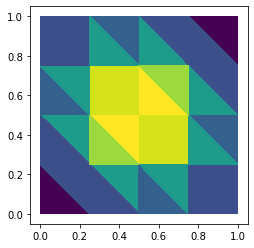

In [26]:
plt.tripcolor(mesh.p[0], mesh.p[1], mesh.t.T, u)
plt.gca().set_aspect(1)

TODO
* Piecewise linear vs. constant plots
* Probes
* Plot basis functions
* Closer look at the indexing
* Compare P1 and P2
* Plotting in 3d

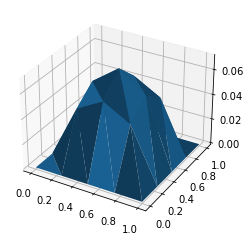

In [ ]:
ax3d = plt.axes(projection='3d')
ax3d.plot_trisurf(mesh.p[0], mesh.p[1], u, triangles=mesh.t.T);